# CAMBAM Workshop: Exploring Single Neuron Excitability with Mathematical and Computational Models

## Brian2 and Model Fitting
##### Nils Koch and Niklas Brake

Example of Brian2 implementation of the Izhikevich model and exploration of model fitting


# 1. Brain2


## Izhikevich model implemented in brian2
Izhikevich model with parameters  $a$, $b$, $c$, and $d$ and a step current $I$
\begin{align}
C \frac{dV}{dt} &= k(V - V_r) (V -V_t) - u + I \\
\frac{du}{dt} &= a (b (V - V_r) - u)
\end{align}
and the restting criterion is
\begin{equation}
\text{if } V\ge V_{th} \text{: then } V\leftarrow c, u \leftarrow u+d
\end{equation}

For this notebook we will use
$V_r = -60mV$
$V_t = -40mV$
$V_{th} = 30mV$
$C = 100pF$
$k = 1mS$


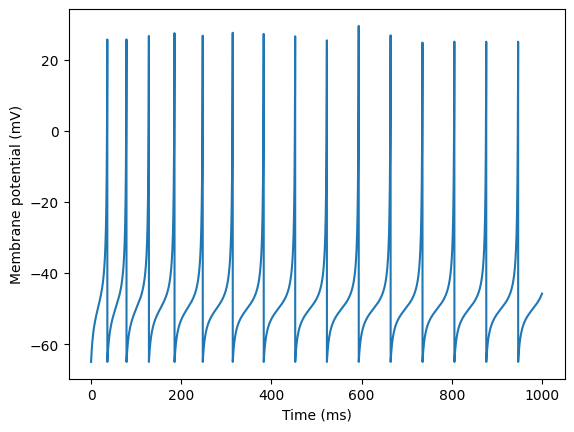

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import brian2
from brian2 import NeuronGroup, Synapses, SpikeMonitor, StateMonitor
from brian2 import ms, mV, nA
from brian2 import defaultclock, run

def reset_brian():
    brian2.start_scope()
    if 'neuron' in locals():
        del neuron

reset_brian()

# Define the Izhikevich model equations
eqs = """dv/dt = 1*((v+60)*(v+40) - u + I )/(100*ms) : 1
         du/dt = (a*(b*(v+60) - u))/ms  : 1
         I : 1
         a : 1
         b : 1
         c : 1
         d : 1
       """
# Create a neuron group with a single neuron using the model and parameters
neuron = NeuronGroup(1, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")

# Set the parameters for the model
neuron.a = 0.01
neuron.b = 0.5
neuron.c = -65
neuron.d = 2

# Set the initial values for the neuron's membrane potential and recovery variable
neuron.v = -65
neuron.u = "b*v"

# Set the input current for the neuron
neuron.I =  125 # nA

# Create a monitor to record the neuron's membrane potential and input current
monitors = StateMonitor(neuron, ['v', 'I'], record=True)

# Run the simulation for 100 milliseconds
dur = 1000 * ms
run(dur)

y_obs =  monitors.v[0]
t_obs = monitors.t/ms

# Plot the neuron's membrane potential and input current over time
plt.figure()
plt.plot(t_obs,y_obs)
plt.ylabel('Membrane potential (mV)')
plt.xlabel('Time (ms)')
plt.show()


Let's extract a few features of this spike train

In [2]:
import efel
efel_feat = efel.getFeatureNames()

efel_feat = ['AP_amplitude','AP_duration','AP_height', 'AP_width', 'ISI_CV', 'ISI_values', 'Spikecount_stimint', 'adaptation_index',  'irregularity_index', 'mean_frequency',  'spike_half_width']

trace1 = {}
trace1['T'] = monitors.t/ms
trace1['V'] = monitors.v[0]
trace1['stim_start'] = [0.]
trace1['stim_end'] = [1000.]

# Multiple traces can be passed to the eFEL at the same time, so the argument should be a list
original_traces = [trace1]

# feature extraction settings
efel.api.setThreshold(-20)  # set spike detection threshold
efel.setDoubleSetting('interp_step', 0.1)  # set interpolation step to sampling rate or simulation step size
efel.setIntSetting('ignore_first_ISI', 0)

# extract features
original_traces_results = efel.getFeatureValues(original_traces, efel_feat, raise_warnings=False)
print(original_traces_results)

[{'AP_amplitude': array([44.21213054, 43.09361946, 44.83647945, 45.42538941, 44.8194521 ,
       45.48127892, 45.203223  , 44.66054623, 42.71417633, 47.05105903,
       44.86995933, 42.20557106, 42.42259708, 42.39445311, 42.39811693]), 'AP_duration': array([2.1, 2. , 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2. , 2.1, 2.1, 2. , 2. ,
       2. , 2. ]), 'AP_height': array([25.63110892, 25.65577941, 26.62532609, 27.40509685, 26.69839468,
       27.52455119, 27.19348903, 26.53382211, 25.39866964, 29.44931093,
       26.79304732, 24.76533484, 25.03630821, 25.00118264, 25.00575558]), 'AP_width': array([2.1, 2.1, 2.1, 2.2, 2.1, 2.2, 2.2, 2.1, 2.1, 2.2, 2.2, 2.1, 2.1,
       2.1, 2.1]), 'ISI_CV': array([0.13969156]), 'ISI_values': array([42.5, 49.7, 56.8, 62.6, 66.5, 68.7, 69.8, 70.3, 70.6, 70.7, 70.7,
       70.7, 70.7, 70.7]), 'Spikecount_stimint': array([15]), 'adaptation_index': array([0.00994596]), 'irregularity_index': array([2.01428571]), 'mean_frequency': array([15.83949314]), 'spike_half_width': 

# 2. The Fitting Problem

We have used an Izhikevich model to simulate a spike train and extracted electrophysiological features. Can we recover the original parameters of this model from the spike train and features? To do this we will use genetic algorithm to fit the model to the data.

### Genetic Algorithm Fitting with PyGAD

There are many methods (and packages) of fitting neuronal models. Today we will use the PyGAD package to use the genetic algorithm to do our fitting.

The genetic algorithm is a gradient free metaheuristic optimization algorithm inspired by the principles of natural selection and evolution used for complex nonlinear optimizations.


This approach involves initializing a population of models who's fitness (1/error) is evaluated and individual from this population are selected to produce new individuals. 2 operations occur in the production of new individuals: crossover or exchange of genetic material and mutation. A new population is produced including te offspring and some of the previous generation. This is then repeated and parameter space is explored to find the parameters that maximize fitness (or minimize error)

Define a fitness function for the error between timeseries

In [3]:
# reset and redefine Izhikevich neuron
reset_brian()
neuron = NeuronGroup(1, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")

def calculate_fitness(solution, y_obs):
    a1, b1, c1, d1, I_input = solution

    # set parameters to best fitting solution
    neuron.a = a1
    neuron.b = b1
    neuron.c = c1
    neuron.d = d1
    neuron.I = I_input

    # initial conditions
    neuron.v = -65
    neuron.u = "b*v"

    monitors = StateMonitor(neuron, ['v'], record=True, dt=0.1*ms)
    dur = 1000 * ms
    run(dur)
    y_pred = monitors.v[0]
    mse = np.mean((y_pred - y_obs) ** 2) # mean square error
    return 1 / mse

# Define the fitness function
def fitness_func(solution, solution_idx):
    return calculate_fitness(solution, y_obs)

Setup genetic algorithm and options

In [4]:
import pygad
# Define the bounds for the parameter values
# param_bounds = np.array([[0, 1], [0, 1], [0, 10]]) # param 1 can be 0 or 1
# use dictionary for continuous values i.e. in range [low, high) i
gene_space = [{'low': 0.005, 'high': 0.015},
              {'low': 0.4, 'high': 0.6},
              {'low': -70., 'high': -60.},
              {'low': 1., 'high': 3.},
              {'low': 75, 'high': 175}]

# Create the genetic algorithm object
# all parameters for pygad.GA found here https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html
ga = pygad.GA(initial_population=None,  #if None, let pyGAD initialize
              sol_per_pop=10,  # number of individuals
              num_genes=5,  # number of genes
              fitness_func=fitness_func,
              num_generations=50,
              num_parents_mating=6,
              gene_type=float,
              mutation_num_genes=3,
              gene_space=gene_space,  # bounds on parameters
              random_seed=0, # for reproducibility
              )

Run genetic algorithm and plot fitness over generations

In [5]:
ga.run()
solution, solution_fitness, _ = ga.best_solution() # Get the best solution
print("Best solution: ", solution)

Best solution:  [ 7.37972543e-03  5.52385302e-01 -6.16541362e+01  2.53013990e+00
  9.88413281e+01]


Plot best solution and compare to y_obs

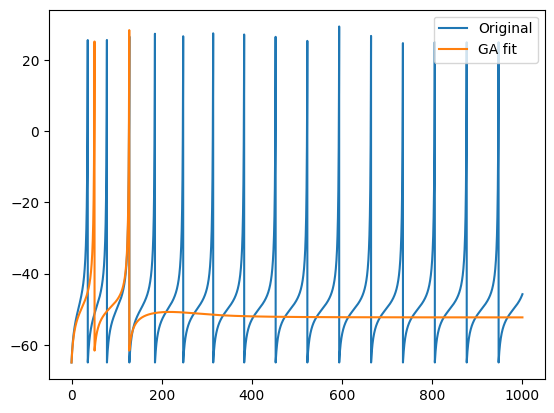

In [6]:
# reset and redefine Izhikevich neuron
reset_brian()
neuron = NeuronGroup(1, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")

# set parameters to best fitting solution
neuron.a = solution[0]
neuron.b = solution[1]
neuron.c = solution[2]
neuron.d = solution[3]
neuron.I = solution[4]

# initialization
neuron.v = -65
neuron.u = "b*v"

# record V
monitors = StateMonitor(neuron, ['v'], record=True)

# run for 1 second
dur = 1000 * ms
run(dur)

# plot original model and fitting solution
fig, ax = plt.subplots()
ax.plot(t_obs, y_obs, label='Original', color='tab:blue')
ax.plot(monitors.t/ms, monitors.v[0], label='GA fit', color='tab:orange')
ax.legend()
plt.show()


### What if we fit based on electrophysiological features instead of voltage trace?

Define a new fitness function

In [7]:
import efel
reset_brian()
neuron = NeuronGroup(1, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")
# feature extraction settings
efel.api.setThreshold(-20)  # set spike detection threshold
efel.setDoubleSetting('interp_step', 0.1)  # set interpolation step to sampling rate or simulation step size
efel.setIntSetting('ignore_first_ISI', 0)

def calculate_fitness_features(solution, original_traces_results):
    a1, b1, c1, d1, I_input = solution

    # set parameters
    neuron.a = a1
    neuron.b = b1
    neuron.c = c1
    neuron.d = d1
    neuron.I = I_input

    # initialization
    neuron.v = -65
    neuron.u = "b*v"

    # record V
    monitors = StateMonitor(neuron, ['v'], record=True)

    # run for 1 second
    dur = 1000 * ms
    run(dur)

    # create traces dict for efel feature extraction
    trace1 = {}
    trace1['T'] = monitors.t/ms
    trace1['V'] = monitors.v[0]
    trace1['stim_start'] = [0.]
    trace1['stim_end'] = [1000.]

    # extract features using efel
    traces_results = efel.getFeatureValues([trace1], efel_feat, raise_warnings=False)

    # calculate error
    if traces_results[0]['Spikecount_stimint'][0] == 0: # if no spiking occurs impose large error
        err = np.inf
    else:
        err = []
        for feat in efel_feat:
            err.append(((np.mean(traces_results[0][feat]) - np.mean(original_traces_results[0][feat])) / np.mean(original_traces_results[0][feat]))**2)

    mse = np.sum(err) # sum over all features
    return 1 / mse

# Define the fitness function
def fitness_func_features(solution, solution_idx):
    return calculate_fitness_features(solution, original_traces_results)

Setup new genetic algorithm and options with new fitness function

In [8]:
ga_features = pygad.GA(initial_population=None,  #if None, let pyGAD initialize
              sol_per_pop=10,  # number of individuals
              num_genes=5,  # number of genes
              fitness_func=fitness_func_features,
              num_generations=50,
              num_parents_mating=6,
              gene_type=float,
              mutation_num_genes=3,
              gene_space=gene_space,  # same bounds on parameters as before
              random_seed=0, # for reproducibility
              )

Run this genetic algorithm and plot fitness over generations

In [9]:
ga_features.run()
solution_features, solution_fitness_features, _ = ga_features.best_solution()  # Get the best solution
print("Best solution: ", solution_features)

Best solution:  [ 1.04881350e-02  5.43037873e-01 -6.39723662e+01  2.08976637e+00
  1.17365480e+02]


Plot best solution for fit on features and compare to y_obs

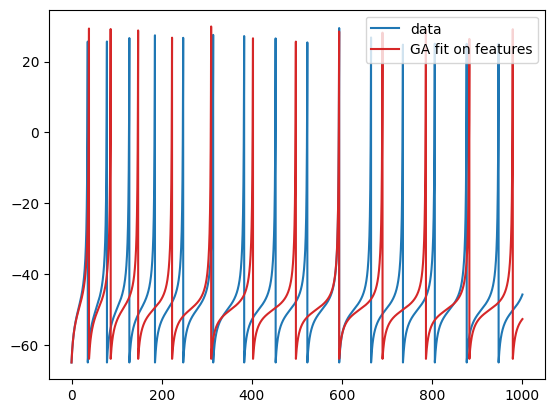

In [10]:
# reset and redefine Izhikevich neuron
reset_brian()
neuron = NeuronGroup(1, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")

# set parameters to best fitting solution
neuron.a = solution_features[0]
neuron.b = solution_features[1]
neuron.c = solution_features[2]
neuron.d = solution_features[3]
neuron.I = solution_features[4]

# initialization
neuron.v = -65
neuron.u = "b*v"

# record V
monitors = StateMonitor(neuron, ['v'], record=True)

# run for 1 second
dur = 1000 * ms
run(dur)

# plot original model and fitting solution
fig, ax = plt.subplots()
ax.plot(t_obs , y_obs, label='data', color='tab:blue')
ax.plot(monitors.t / ms, monitors.v[0], label='GA fit on features', color='tab:red')
ax.legend()
plt.show()

# 3. Your Turn! Time to try fitting parameters to capture data

Import file from DANDI recording at the Allen Brain Institute - same file and code as in Computer lab 1

WARNING    c:\users\nilsk\appdata\local\programs\python\python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
 [py.warnings]
WARNING    c:\users\nilsk\appdata\local\programs\python\python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
 [py.warnings]


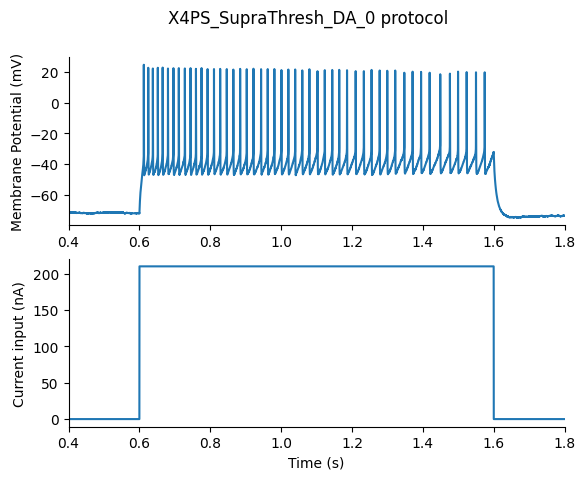

In [11]:
from dandi.dandiapi import DandiAPIClient
from dandi.dandiarchive import parse_dandi_url
import fsspec
import pynwb
import h5py
from fsspec.implementations.cached import CachingFileSystem

dandiset_id = '000020'  # Patch-seq recordings from mouse visual cortex Gouwens et al. 2021 https://doi.org/10.1016/j.cell.2020.09.057
t = parse_dandi_url('https://api.dandiarchive.org/api/dandisets/{}/'.format(dandiset_id))
c = t.get_client()
d_set = t.get_dandiset(client=c,lazy=True)
assets = d_set.get_assets()
asset_list = [i for i in assets]
filepath = asset_list[0].path # select the first file

# get the url for streaming
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

# create a virtual filesystem based on the http protocol and use caching to save accessed data to RAM.
fs = CachingFileSystem(fs=fsspec.filesystem("http"),cache_storage="nwb-cache", )
desired_protocol = 'X4PS_SupraThresh_DA_0'
fig, axs = plt.subplots(2,1)
with fs.open(s3_url, "rb") as f:
    with h5py.File(f) as file:
        with pynwb.NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read() # required to open file
            # get list of sweeps
            sweep_list = [i for i in nwbfile.stimulus.keys()]
            acq_list =[i for i in nwbfile.acquisition.keys()] # should match sweep_list

            # get description/protocol for every sweeep
            stim_descrip = []
            for s in sweep_list:
                stim_descrip.append(nwbfile.stimulus.get(s).stimulus_description)

            # convert lists to arrays
            Stim_descript = np.array(stim_descrip)
            sweep_list_array = np.array(sweep_list)

            protocols = np.unique(stim_descrip) # find unique protocol labels
            protocol_sweeps = {} # dictionary with protocol: sweeps in protocol pairing
            protocol_sweeps_ids = {}  # dictionary with protocol: sweeps in protocol pairing
            for i in range(0, len(protocols)):
                protocol_sweeps[protocols[i]] = sweep_list_array[(Stim_descript == protocols[i])]
                protocol_sweeps_ids[protocols[i]] = np.argwhere(Stim_descript == protocols[i])

            p_sweeps_ind = protocol_sweeps_ids[desired_protocol] # indices of sweeps belonging to protocol
            # for sweep in p_sweeps_ind: #for each sweep in protocol
            sweep = p_sweeps_ind[-1] #last sweep
            num_samples = nwbfile.stimulus.get(sweep_list[sweep[0]]).num_samples # length of sweep
            samp_rate = nwbfile.stimulus.get(sweep_list[sweep[0]]).rate # sample rate

            # get time, voltage and current input of the sweep
            t = np.arange(0, num_samples, 1) * (1 / samp_rate)
            V = nwbfile.acquisition.get(acq_list[sweep[0]]).data[:]
            I = nwbfile.stimulus.get(sweep_list[sweep[0]]).data[:]
            Istart = np.argmin(np.abs(t-0.6))
            Istop = np.argmin(np.abs(t-1.6))
            # plot the voltage traces and current inputs for the sweep
            axs[0].plot(t, V)
            axs[1].plot(t, I)


#  label plot and set x limits
xlim = (0.4, 1.8)
axs[0].set_xlim(xlim)
axs[0].set_ylabel('Membrane Potential (mV)')
axs[1].set_xlim(xlim)
axs[1].set_ylabel('Current input (nA)')
axs[1].set_xlabel('Time (s)')
for ax in axs.reshape(-1):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.suptitle('{} protocol'.format(desired_protocol))
plt.show()

So we have the data, now it's up to you to fill in the following cells and fit the data!

To start lets extract Electrophysiological Features

In [13]:
# generate dictionary for the trace
trace = {}

# get a list of traces to analyze
traces = [trace]

# feature extraction settings
efel.api.setThreshold(-20)  # set spike detection threshold
efel.setDoubleSetting('interp_step', 1/samp_rate)  # set interpolation step to sampling rate or simulation step size
efel.setIntSetting('ignore_first_ISI', 0)

# extract features
Dandi_traces_results =

Let's start by trying to fit the model by hand. For convenience, we define a function that runs and plots the model overlayed on the data for input parameter values

In [19]:
# reset and redefine Izhikevich neuron
reset_brian()
neuron = NeuronGroup(1, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")
def run_model(a=0.02,b=0.25,c=-65,d=2, Imag=150):
    # redefine model with new parameter

    # set parameters
    neuron.a = a
    neuron.b = b
    neuron.c = c
    neuron.d = d
    neuron.I = Imag

    # initialization
    neuron.v = -65
    neuron.u = "b*v"

    # record V
    monitors = StateMonitor(neuron, ['v'], record=True)

    # run for 1 second
    dur = 1000 * ms
    run(dur)

    # plot the model with the data
    fig, ax = plt.subplots()
    ax.plot((t[Istart:Istop] - t[Istart])*1000, V[Istart:Istop], label='Data', color='tab:blue')
    ax.plot(monitors.t / ms, monitors.v[0], label='Model', color='tab:orange')
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

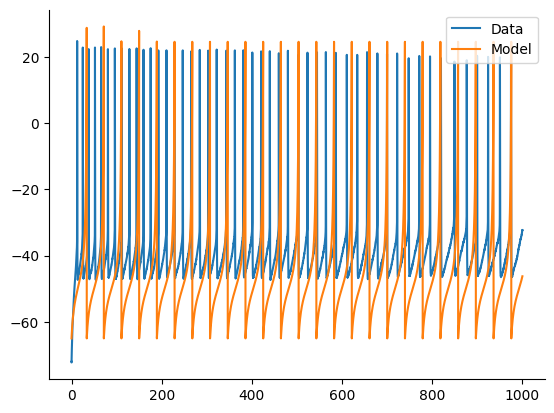

In [20]:
run_model(a=0.04,b=0.25,c=-65,d=2, Imag=150)

You can also add feature extraction to ```run_model ``` to compare the features we extracted from the data to those of the spike train simulated at certain parameters.

### Can we do this in an automated way using the genetic algorithm?

To start, we need to set up the fitness function for the genetic algorithm. You can choose if you would like to fit the time series or the electrophysiological features.

In [ ]:
import efel
efel_feat = ['ISI_values', 'Spikecount_stimint', 'adaptation_index']

# feature extraction settings
efel.api.setThreshold(-20)  # set spike detection threshold
efel.setDoubleSetting('interp_step', 0.1)  # set interpolation step to sampling rate or simulation step size
efel.setIntSetting('ignore_first_ISI', 0)

# reset and redefine Izhikevich neuron
reset_brian()
neuron = NeuronGroup(1, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")

# write your fitness function, either with the spike train or with the features
def calculate_fitness_dandi(solution, y_obs):


    # set parameters


    # initialization


    # record V

    # run for 1 second



    # create traces dict for efel feature extraction


    # extract features using efel


    mse =
    return 1 / mse

# Define the fitness function
def fitness_func_features(solution, solution_idx):
    return calculate_fitness_dandi(solution, y_obs)

Now we need to set-up the genetic algorithm parameters and options

In [ ]:
# bounds on parameters
gene_space = []

# setup up genetic algorithm and options
ga_dandi = pygad.GA((initial_population=None,  #if None, let pyGAD initialize
              sol_per_pop=,  # number of individuals
              num_genes=5,  # number of genes
              fitness_func=calculate_fitness_dandi,
              num_generations=,
              num_parents_mating=,
              gene_type=float,
              mutation_num_genes=,
              gene_space=gene_space,  # same bounds on parameters as before
              )

We can run the genetic algorithm and see what the best parameter set is

In [ ]:
# run the genetic algorithm

# Get the best solution


Finallly we can run the model with the best parameter set, and plot the result with the data to see how well it worked

In [ ]:
# run the model with best solution


fig, ax = plt.subplots()
# plot data

# plot genetic algorithm fitting result


plt.show()